# 📘 02_classical_models.ipynb

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# 🔹 Load Data
X_kmer = np.load("data/processed/X_kmer.npy")
X_onehot = np.load("data/processed/X_onehot.npy")
y = np.load("data/processed/y_labels.npy")

print("✅ Loaded:")
print("X_kmer:", X_kmer.shape)
print("X_onehot:", X_onehot.shape)
print("y_labels:", y.shape)

# 🔹 Train/Test Split
Xk_train, Xk_test, yk_train, yk_test = train_test_split(
    X_kmer, y, test_size=0.3, random_state=42, stratify=y
)
Xo_train, Xo_test, yo_train, yo_test = train_test_split(
    X_onehot, y, test_size=0.3, random_state=42, stratify=y
)

✅ Loaded:
X_kmer: (131, 64)
X_onehot: (131, 402, 5)
y_labels: (131,)


# 🔹 1. Support Vector Machine (SVM)

In [8]:
svm = SVC(kernel='rbf', probability=True)
svm.fit(Xk_train, yk_train)
y_pred_svm = svm.predict(Xk_test)
y_proba_svm = svm.predict_proba(Xk_test)[:, 1]

# 🔹 2. Random Forest

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(Xk_train, yk_train)
y_pred_rf = rf.predict(Xk_test)
y_proba_rf = rf.predict_proba(Xk_test)[:, 1]

# 🔹 3. CNN for One-Hot Encoded Sequences

In [10]:
cnn = Sequential([
    Conv1D(64, 5, activation='relu', input_shape=Xo_train.shape[1:]),
    MaxPooling1D(2),
    Dropout(0.2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_history = cnn.fit(Xo_train, yo_train, epochs=10, batch_size=16, validation_split=0.2, verbose=1)
y_pred_cnn = (cnn.predict(Xo_test) > 0.5).astype("int32").flatten()
y_proba_cnn = cnn.predict(Xo_test).flatten()

Epoch 1/10
5/5 [==============================] - 6s 65ms/step - loss: 0.7003 - accuracy: 0.7222 - val_loss: 0.5870 - val_accuracy: 0.7368
Epoch 2/10
5/5 [==============================] - 0s 9ms/step - loss: 0.5330 - accuracy: 0.7222 - val_loss: 0.6768 - val_accuracy: 0.7368
Epoch 3/10
5/5 [==============================] - 0s 9ms/step - loss: 0.4288 - accuracy: 0.8333 - val_loss: 0.5644 - val_accuracy: 0.7895
Epoch 4/10
5/5 [==============================] - 0s 9ms/step - loss: 0.3429 - accuracy: 0.8750 - val_loss: 0.5236 - val_accuracy: 0.7895
Epoch 5/10
5/5 [==============================] - 0s 8ms/step - loss: 0.2755 - accuracy: 0.9167 - val_loss: 0.4456 - val_accuracy: 0.8421
Epoch 6/10
5/5 [==============================] - 0s 9ms/step - loss: 0.2038 - accuracy: 0.9444 - val_loss: 0.3571 - val_accuracy: 0.7895
Epoch 7/10
5/5 [==============================] - 0s 8ms/step - loss: 0.1508 - accuracy: 0.9583 - val_loss: 0.4029 - val_accuracy: 0.8421
Epoch 8/10
5/5 [=================

# 🧪 Evaluation Function

In [11]:
def evaluate_model(y_true, y_pred, y_proba, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    print(f"📊 {name} Results:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# 📊 Evaluate All Models

📊 SVM Results:
Accuracy:  0.9750
Precision: 0.9630
Recall:    1.0000
F1-score:  0.9811
AUC:       0.9725


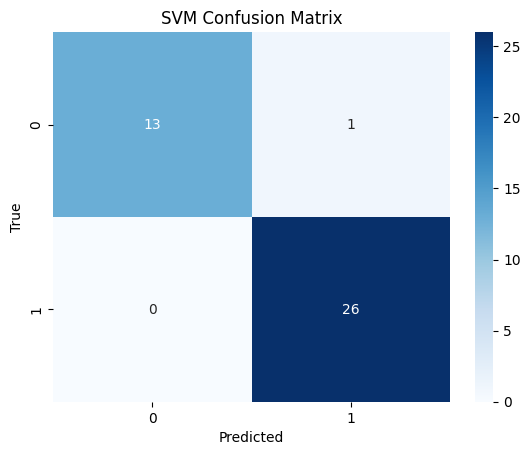

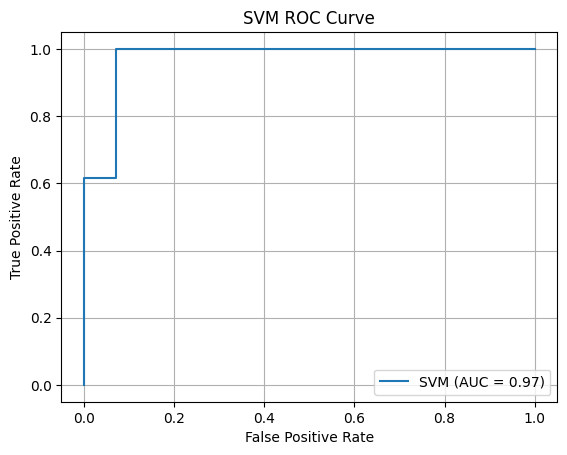

📊 Random Forest Results:
Accuracy:  0.9250
Precision: 0.9600
Recall:    0.9231
F1-score:  0.9412
AUC:       0.9560


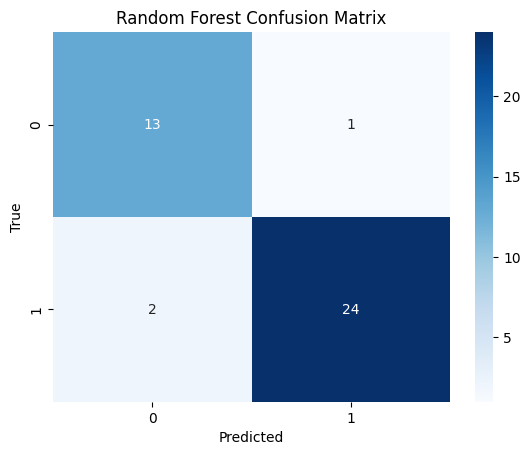

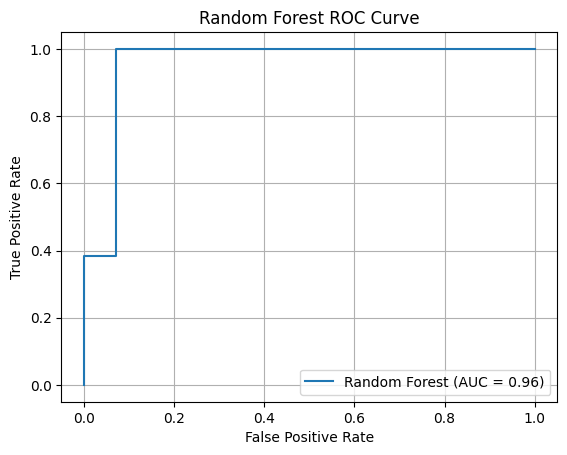

📊 CNN Results:
Accuracy:  0.8750
Precision: 0.8621
Recall:    0.9615
F1-score:  0.9091
AUC:       0.9835


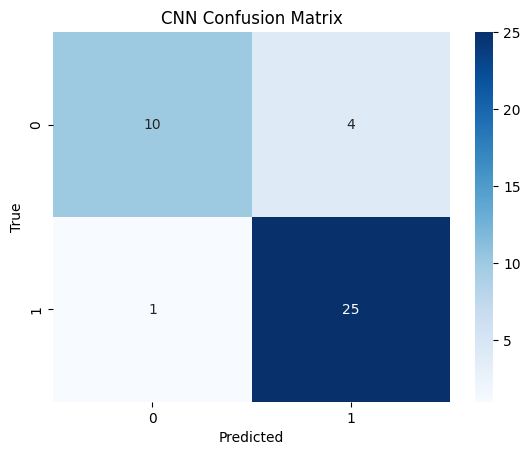

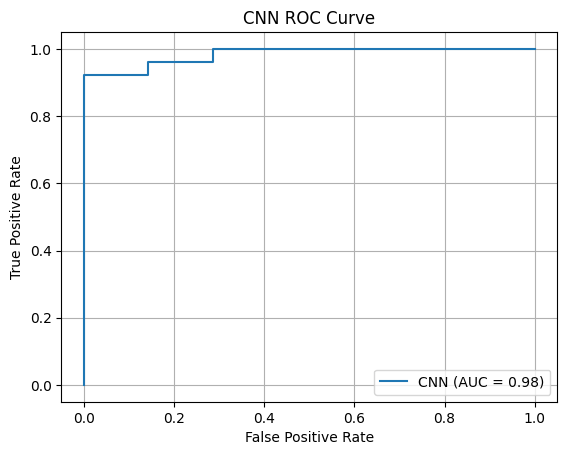

🎉 Model training and evaluation complete.


In [12]:
evaluate_model(yk_test, y_pred_svm, y_proba_svm, "SVM")
evaluate_model(yk_test, y_pred_rf, y_proba_rf, "Random Forest")
evaluate_model(yo_test, y_pred_cnn, y_proba_cnn, "CNN")

print("🎉 Model training and evaluation complete.")